<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Masalah_Dying_ReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Studi Kasus Dying ReLU dengan California Housing**

Contoh ini menggunakan _dataset_ **California Housing** untuk tugas regresi, yang merupakan alternatif modern dan etis untuk _Boston Housing_. Kita tetap akan menggunakan **Learning Rate yang sangat tinggi** sebagai pemicu sengaja untuk masalah **Dying ReLU**.

### **1. Persiapan Lingkungan dan Data (California Housing)**

Kita akan menggunakan `fetch_california_housing` dari `sklearn.datasets`.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Mengambil Dataset California Housing
california = fetch_california_housing()

X = california.data
y = california.target

# 2. Preprocessing Data
# Normalisasi dan Standardisasi untuk Input (X) dan Target (y)
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
# Target (y) juga distandarisasi agar model lebih stabil (standar di PyTorch)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi ke Tensor PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Regresi, perlu [N, 1]
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

INPUT_SIZE = X_train.shape[1] # Akan disesuaikan otomatis (California Housing memiliki 8 fitur)
OUTPUT_SIZE = 1 # Tugas Regresi
HIDDEN_SIZE = 64

print(f"Jumlah Fitur Input (California Housing): {INPUT_SIZE}")

Jumlah Fitur Input (California Housing): 8


### **2. Definisi Model Jaringan Saraf Tiruan (JST) untuk Regresi**

Arsitektur model tetap sama, menggunakan lapisan tersembunyi dengan **ReLU** dan lapisan _output_ Linier.

In [3]:
class DeepRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepRegressor, self).__init__()
        # Lapisan tersembunyi dengan ReLU
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        # Lapisan output dengan Linear (Regresi)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

### **3. Pelatihan: Kontrol vs. Dying ReLU**

Fungsi pelatihan dimodifikasi sedikit untuk secara eksplisit **menghitung jumlah neuron yang mati** dengan memeriksa _output_ lapisan pra-aktivasi () setelah pelatihan.

In [4]:
def train_and_get_metrics(model, X, y, lr, epochs=200):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    # Pelatihan
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    # Analisis Dying ReLU: Cek Lapisan Pertama (fc1)
    model.eval()
    with torch.no_grad():
        # Dapatkan nilai pra-aktivasi (z) dari fc1
        z1 = model.fc1(X)
        z1_np = z1.numpy()

        # Neuron dianggap "mati" jika z < 0 untuk setidaknya 99% dari semua input training
        # Ini berarti neuron tersebut tidak akan pernah memberikan gradien > 0
        dying_neurons = np.sum(np.mean(z1_np < 0, axis=0) > 0.99)

    return loss_history, dying_neurons

# Inisialisasi Model
model_control = DeepRegressor(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
model_dying = DeepRegressor(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Pelatihan
epochs = 200

# Model Kontrol (LR rendah, Konvergensi Stabil)
loss_control, dying_c = train_and_get_metrics(model_control, X_train, y_train, lr=0.001, epochs=epochs)

# Model Dying ReLU (LR tinggi, Memicu Dying ReLU)
# Nilai 1.0 (atau lebih) seringkali terlalu agresif untuk Adam dan ReLU
loss_dying, dying_d = train_and_get_metrics(model_dying, X_train, y_train, lr=1.0, epochs=epochs)

### **4. Analisis dan Visualisasi Hasil**

Visualisasi akan menunjukkan perbedaan signifikan dalam stabilitas dan kinerja _Loss_ antara kedua model.

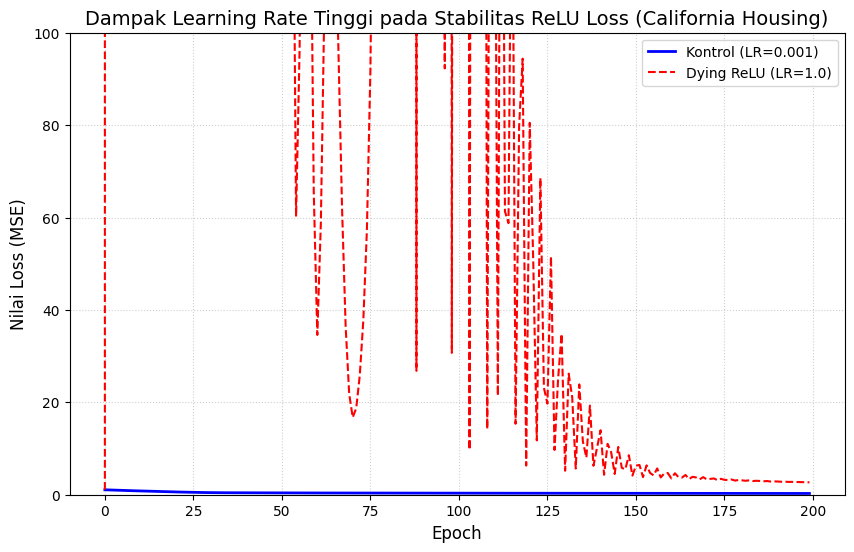


--- Analisis Dying ReLU ---
Total Neuron di Lapisan Tersembunyi (fc1): 64
Model Kontrol (LR=0.001):
  Loss Akhir: 0.2727
  Jumlah Neuron 'Mati': 0

Model Dying ReLU (LR=1.0):
  Loss Akhir: 2.6869 (Loss Sangat Tinggi/Stagnan)
  Jumlah Neuron 'Mati': 2


In [21]:
# Visualisasi Kurva Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_control, label='Kontrol (LR=0.001)', color='blue', linewidth=2)
plt.plot(loss_dying, label='Dying ReLU (LR=1.0)', color='red', linestyle='--')

plt.title('Dampak Learning Rate Tinggi pada Stabilitas ReLU Loss (California Housing)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Nilai Loss (MSE)', fontsize=12)
#plt.ylim(0, max(max(loss_control), max(loss_dying))*1.1) # Sesuaikan batas Y
plt.ylim(0, 100) # Sesuaikan batas Y
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

# Kesimpulan Hasil
print("\n--- Analisis Dying ReLU ---")
print(f"Total Neuron di Lapisan Tersembunyi (fc1): {HIDDEN_SIZE}")
print(f"Model Kontrol (LR=0.001):")
print(f"  Loss Akhir: {loss_control[-1]:.4f}")
print(f"  Jumlah Neuron 'Mati': {dying_c}")

print(f"\nModel Dying ReLU (LR=1.0):")
print(f"  Loss Akhir: {loss_dying[-1]:.4f} (Loss Sangat Tinggi/Stagnan)")
print(f"  Jumlah Neuron 'Mati': {dying_d}")